In [1]:
import h5py as h5
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, LinearSVR
from sklearn import preprocessing
import calendar as cal
import seaborn as sns
import datetime as dt
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '/home/sadat/Documents/DSE/Data/yogurt.h5'
df = pd.read_hdf(path, key='panel')
df.head()

,COLUPC,DOLLARS,IRI_KEY,MINUTE,OUTLET,PANID,UNITS,WEEK,file
0,17047000300,0.99,1097117,5068.0,DK,3138826,1.0,1514,yogurt_PANEL_DK_1479_1530.DAT
1,17047000302,0.89,1097117,2224.0,DK,3138826,1.0,1489,yogurt_PANEL_DK_1479_1530.DAT
2,17047000650,0.89,1097117,6551.0,DK,3138826,1.0,1488,yogurt_PANEL_DK_1479_1530.DAT
3,17047000650,2.97,1097117,6177.0,DK,3182048,3.0,1526,yogurt_PANEL_DK_1479_1530.DAT
4,17047001372,1.49,1097117,973.0,DK,3184911,1.0,1495,yogurt_PANEL_DK_1479_1530.DAT


#Feature Engineering

####Adjust time features

Convert WEEK and MINUTE to DATETIME

In [4]:
def get_datetime(week, minute):
    week, minute = int(week), int(minute)
    # Reference orginal date is September 3, 1979
    ref_orginal = dt.date.toordinal(dt.date(1979, 9, 3))
    # Convert minutes to days, hours, minutes
    days, hours, mins = (minute / 1440), ((minute % 1440) / 60), ((minute % 1440) % 60)
    # Convert from ordinal.
    return dt.datetime.fromordinal(ref_orginal + (week - 1) * 7 + days).replace(
        hour=hours, minute=mins)

week = df['WEEK'].values
minute = df['MINUTE'].fillna(df['MINUTE'].median()).values
datetime = []

for w,m in zip(week,minute):
    datetime.append(get_datetime(w,m))

df = df.drop(['MINUTE','WEEK'], axis=1)
df['DATETIME']=datetime

In [5]:
df.head()

,COLUPC,DOLLARS,IRI_KEY,OUTLET,PANID,UNITS,file,DATETIME
0,17047000300,0.99,1097117,DK,3138826,1.0,yogurt_PANEL_DK_1479_1530.DAT,2008-09-04 12:28:00
1,17047000302,0.89,1097117,DK,3138826,1.0,yogurt_PANEL_DK_1479_1530.DAT,2008-03-11 13:04:00
2,17047000650,0.89,1097117,DK,3138826,1.0,yogurt_PANEL_DK_1479_1530.DAT,2008-03-07 13:11:00
3,17047000650,2.97,1097117,DK,3182048,3.0,yogurt_PANEL_DK_1479_1530.DAT,2008-11-28 06:57:00
4,17047001372,1.49,1097117,DK,3184911,1.0,yogurt_PANEL_DK_1479_1530.DAT,2008-04-21 16:13:00


Get the following:

- Month of year
- Hour of day
- Day of week

In [6]:
df['MONTH'] = df.DATETIME.dt.month
df['HOUR'] = df.DATETIME.dt.hour
df['WEEK'] = df.DATETIME.dt.dayofweek
df = df.drop(['DATETIME'], axis=1)

In [7]:
df.head()

,COLUPC,DOLLARS,IRI_KEY,OUTLET,PANID,UNITS,file,MONTH,HOUR,WEEK
0,17047000300,0.99,1097117,DK,3138826,1.0,yogurt_PANEL_DK_1479_1530.DAT,9,12,3
1,17047000302,0.89,1097117,DK,3138826,1.0,yogurt_PANEL_DK_1479_1530.DAT,3,13,1
2,17047000650,0.89,1097117,DK,3138826,1.0,yogurt_PANEL_DK_1479_1530.DAT,3,13,4
3,17047000650,2.97,1097117,DK,3182048,3.0,yogurt_PANEL_DK_1479_1530.DAT,11,6,4
4,17047001372,1.49,1097117,DK,3184911,1.0,yogurt_PANEL_DK_1479_1530.DAT,4,16,0


####Drop redundant columns

In [8]:
df = df.drop(['COLUPC','IRI_KEY','PANID','file'], axis=1)
df.head()

,DOLLARS,OUTLET,UNITS,MONTH,HOUR,WEEK
0,0.99,DK,1.0,9,12,3
1,0.89,DK,1.0,3,13,1
2,0.89,DK,1.0,3,13,4
3,2.97,DK,3.0,11,6,4
4,1.49,DK,1.0,4,16,0


####Create dummies for Outlet

Only picking GR and GK only those have significant sales

In [9]:
dummies_Outlet = pd.get_dummies(df['OUTLET'], prefix= 'OUTLET') 
df = pd.concat([df, dummies_Outlet[['OUTLET_GK ','OUTLET_GR']]], axis=1)
df = df.drop(['OUTLET'], axis=1)
df.head()

,DOLLARS,UNITS,MONTH,HOUR,WEEK,OUTLET_GK,OUTLET_GR
0,0.99,1.0,9,12,3,0.0,0.0
1,0.89,1.0,3,13,1,0.0,0.0
2,0.89,1.0,3,13,4,0.0,0.0
3,2.97,3.0,11,6,4,0.0,0.0
4,1.49,1.0,4,16,0,0.0,0.0


#Clustering

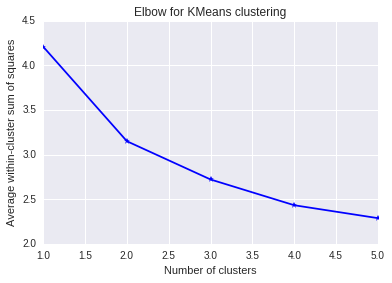

In [12]:
dt_trans = df.values

K = range(1,6)
KM = [KMeans(n_clusters=k, n_jobs=-1).fit(dt_trans) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(dt_trans, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/dt_trans.shape[0] for d in dist]

# elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering');

The elbow curve shows that 3 clusters retain enough information

In [13]:
km = KMeans(n_clusters=3, n_jobs=-1)
km.fit(df.values)
clusters = km.predict(df.values)
data = km.cluster_centers_
df_centers = pd.DataFrame(data, columns=df.columns)

In [14]:
df_centers.head()

,DOLLARS,UNITS,MONTH,HOUR,WEEK,OUTLET_GK,OUTLET_GR
0,1.349876,1.673914,3.462552,16.893819,3.007401,0.213610,7.827426e-01
1,1.646463,1.888590,5.985410,10.898894,3.268975,0.999803,-1.229239e-12
2,1.421487,1.682860,9.360250,16.853968,3.001116,0.220294,7.751621e-01


####Descripton of each cluster:
 
1) This cluster has the lowest sales and occur around March-April around 4pm.
 
2) This cluster has the highest sales and occur June around 10am. These sales occur at GK far more than the other 2 clusters.

3) This cluster has medium sales and occur September around 4pm. 

#Split Data

####Normalize Data

In [10]:
df_norm = df / (df.max() - df.min())

In [11]:
df_norm.head()

,DOLLARS,UNITS,MONTH,HOUR,WEEK,OUTLET_GK,OUTLET_GR
0,0.013842,0.014961,0.818182,0.521739,0.500000,0.0,0.0
1,0.012444,0.014961,0.272727,0.565217,0.166667,0.0,0.0
2,0.012444,0.014961,0.272727,0.565217,0.666667,0.0,0.0
3,0.041527,0.044883,1.000000,0.260870,0.666667,0.0,0.0
4,0.020833,0.014961,0.363636,0.695652,0.000000,0.0,0.0


####Train-Test Split

In [ ]:
X = df_norm.ix[:,1:]
y = df_norm['DOLLARS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=44)

#Feature selection and regression

In [22]:
clf = Pipeline([
  ('feature_selection', SelectKBest(k=6)),
  ('classification', RandomForestRegressor(n_jobs=-1))
])
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.34196106131569942

In [ ]:
clf = Pipeline([
  ('feature_selection', SelectKBest(k=6)),
  ('classification', SVR())
])
clf.fit(X_train, y_train)
clf.score(X_test, y_test)